In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aerial-cactus-identification/sample_submission.csv
/kaggle/input/aerial-cactus-identification/train.zip
/kaggle/input/aerial-cactus-identification/test.zip
/kaggle/input/aerial-cactus-identification/train.csv


In [2]:
datapath = '/kaggle/input/aerial-cactus-identification/'

labels = pd.read_csv(datapath + 'train.csv')
submission = pd.read_csv(datapath + 'sample_submission.csv')

# Visualization

## Distribution of labels

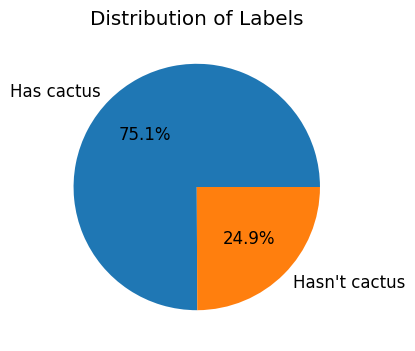

In [3]:
mpl.rc('font', size = 12)
plt.figure(figsize = (4,4))
fig_label = ['Has cactus', 'Hasn\'t cactus']
plt.pie(labels['has_cactus'].value_counts(), labels=fig_label, autopct='%.1f%%')
plt.title('Distribution of Labels')
plt.show()

## Image sample

In [4]:
from zipfile import ZipFile

with ZipFile(datapath + 'train.zip') as zipper:
    zipper.extractall()
    
with ZipFile(datapath + 'test.zip') as zipper:
    zipper.extractall()

In [5]:
import matplotlib.gridspec as gridspec
import cv2

def draw_cactus_image(has_cactus : bool):
    mpl.rc('font', size = 7)
    plt.figure(figsize = (10, 6))
    grid = gridspec.GridSpec(2, 6)
    
    last_has_cactus_img_name = labels[labels['has_cactus'] == int(has_cactus)]['id'][-12:]

    for idx, img_name in enumerate(last_has_cactus_img_name):
        img_path = 'train/' + img_name
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(grid[idx])
        ax.imshow(image)
    plt.tight_layout()
    plt.show()

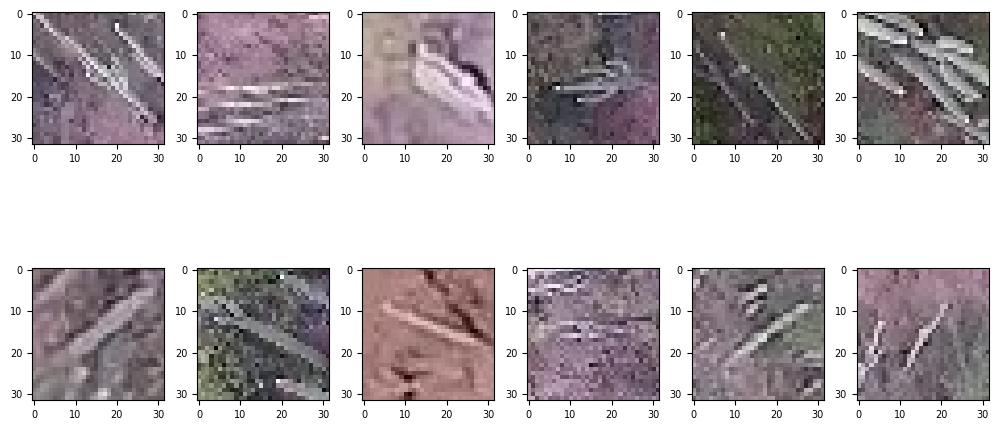

In [6]:
draw_cactus_image(True)

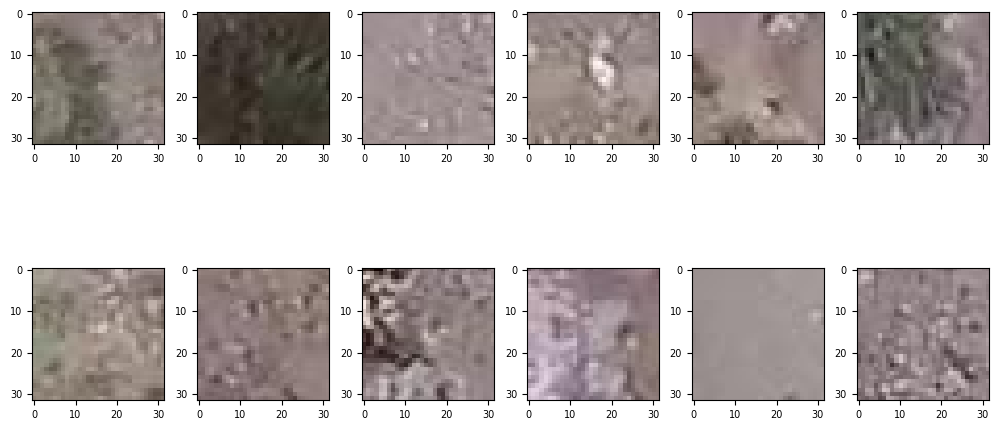

In [7]:
draw_cactus_image(False)

# BaseLine Model

## Setup Pytorch environment

In [10]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Preprocessing

## Split train and validation dataset

In [11]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(labels,
                               test_size = 0.1,
                               stratify=labels['has_cactus'],
                               random_state = 50)
print(len(train), len(valid))

15750 1750


## Define Data augmentation

In [22]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(32, padding_mode='symmetric'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Normalize((0.485, 0.456, 0.406),
                          (0.229, 0.224, 0.225))
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(32, padding_mode='symmetric'),
    transforms.Normalize((0.485, 0.456, 0.406),
                          (0.229, 0.224, 0.225))
])

## Define Image dataset

In [13]:
import cv2
import typing as tp
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, df, img_dir='./', transform:tp.Callable=None):
        super().__init__()
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]
        img_path = self.img_dir + img_id
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.df.iloc[idx, 1]
        
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [23]:
from torchvision import transforms

dataset_train = ImageDataset(df = train, img_dir = 'train/', transform = transform_train)
dataset_valid = ImageDataset(df = valid, img_dir = 'train/', transform = transform_valid)

## Create dataset loader

In [25]:
from torch.utils.data import DataLoader

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

loader_train = DataLoader(dataset = dataset_train, batch_size = 32, shuffle = True,
                          worker_init_fn = seed_worker, generator=g, num_workers=2)
loader_valid = DataLoader(dataset = dataset_valid, batch_size = 32, shuffle = False,
                          worker_init_fn = seed_worker, generator=g, num_workers=2)

# Create Model

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class CactusModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels=32, kernel_size = 3, padding = 2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels=64, kernel_size = 3, padding = 2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels=128, kernel_size = 3, padding = 2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels=256, kernel_size = 3, padding = 2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels=512, kernel_size = 3, padding = 2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.avg_pool = nn.AvgPool2d(kernel_size = 4)
        self.fc1 = nn.Linear(in_features = 512 * 1 * 1, out_features = 64)
        self.fc2 = nn.Linear(in_features = 64, out_features = 2)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avg_pool(x)
        x = x.view(-1, 512 * 1 * 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [17]:
model = CactusModel().to(device)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=0.00006)

## Train model

In [19]:
epochs = 70
for epoch in range(epochs):
    epoch_loss = 0
    for images, labels in loader_train:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f'epoch [{epoch + 1} / {epochs}] - Loss: {epoch_loss/len(loader_train):.4f}')

epoch [1 / 70] - Loss: 0.1293
epoch [2 / 70] - Loss: 0.0739
epoch [3 / 70] - Loss: 0.0540
epoch [4 / 70] - Loss: 0.0465
epoch [5 / 70] - Loss: 0.0386
epoch [6 / 70] - Loss: 0.0355
epoch [7 / 70] - Loss: 0.0338
epoch [8 / 70] - Loss: 0.0285
epoch [9 / 70] - Loss: 0.0275
epoch [10 / 70] - Loss: 0.0243
epoch [11 / 70] - Loss: 0.0235
epoch [12 / 70] - Loss: 0.0213
epoch [13 / 70] - Loss: 0.0207
epoch [14 / 70] - Loss: 0.0193
epoch [15 / 70] - Loss: 0.0191
epoch [16 / 70] - Loss: 0.0202
epoch [17 / 70] - Loss: 0.0165
epoch [18 / 70] - Loss: 0.0147
epoch [19 / 70] - Loss: 0.0152
epoch [20 / 70] - Loss: 0.0148
epoch [21 / 70] - Loss: 0.0153
epoch [22 / 70] - Loss: 0.0111
epoch [23 / 70] - Loss: 0.0119
epoch [24 / 70] - Loss: 0.0116
epoch [25 / 70] - Loss: 0.0115
epoch [26 / 70] - Loss: 0.0131
epoch [27 / 70] - Loss: 0.0117
epoch [28 / 70] - Loss: 0.0101
epoch [29 / 70] - Loss: 0.0127
epoch [30 / 70] - Loss: 0.0095
epoch [31 / 70] - Loss: 0.0102
epoch [32 / 70] - Loss: 0.0104
epoch [33 / 70] -

## Validate model performance

In [26]:
from sklearn.metrics import roc_auc_score

true_list = []
preds_list = []

model.eval()

with torch.no_grad():
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        preds = torch.softmax(outputs.cpu(), dim=1)[:, 1]
        true = labels.cpu()
        preds_list.extend(preds)
        true_list.extend(true)
        
print(f'Validation data roc-auc : {roc_auc_score(true_list, preds_list):.4f}')    



Validation data roc-auc : 0.9998


## Prediction and Submit result

In [27]:
dataset_test = ImageDataset(df = submission, img_dir='test/', transform=transform_valid)
loader_test = DataLoader(dataset = dataset_test, batch_size = 32, shuffle = False)

preds_list = []

model.eval()

with torch.no_grad():
    for images, _ in loader_test:
        images = images.to(device)
        
        outputs = model(images)
        preds = torch.softmax(outputs.cpu(), dim=1)[:, 1].tolist()
        preds_list.extend(preds)
        
submission['has_cactus'] = preds_list
submission.to_csv('submission.csv', index = False)

In [28]:
import shutil

shutil.rmtree('./train')
shutil.rmtree('./test')